In [3]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy import *
from multi_run_v2.initialize_v2 import make_market_index
#from multi_run_v3.backtest import simulate_longonly, simulate_longshort

2023-08-19 22:03:25,812	INFO worker.py:1625 -- Started a local Ray instance.


In [4]:
data = pd.read_pickle('Data/cmktcap_data_final.pickle')

data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [5]:
data = pd.read_pickle("Data/cmktcap_data_reduced.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [6]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [9]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [31]:
data_pp.mask

coin_id,1,10180,10188,1027,1042,10603,10791,109,10903,11047,...,8536,8602,8646,873,8766,8916,9119,938,9444,9903
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
2023-04-13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
2023-04-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0


In [7]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Value Weighted, Marketcap Capped 

In [10]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       #num_cap=0.95, # 5% capped
                                                                       margin ='cross',
                                                                       coin_group=10,
                                                                       leverage_ratio=2) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [11]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [12]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [13]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

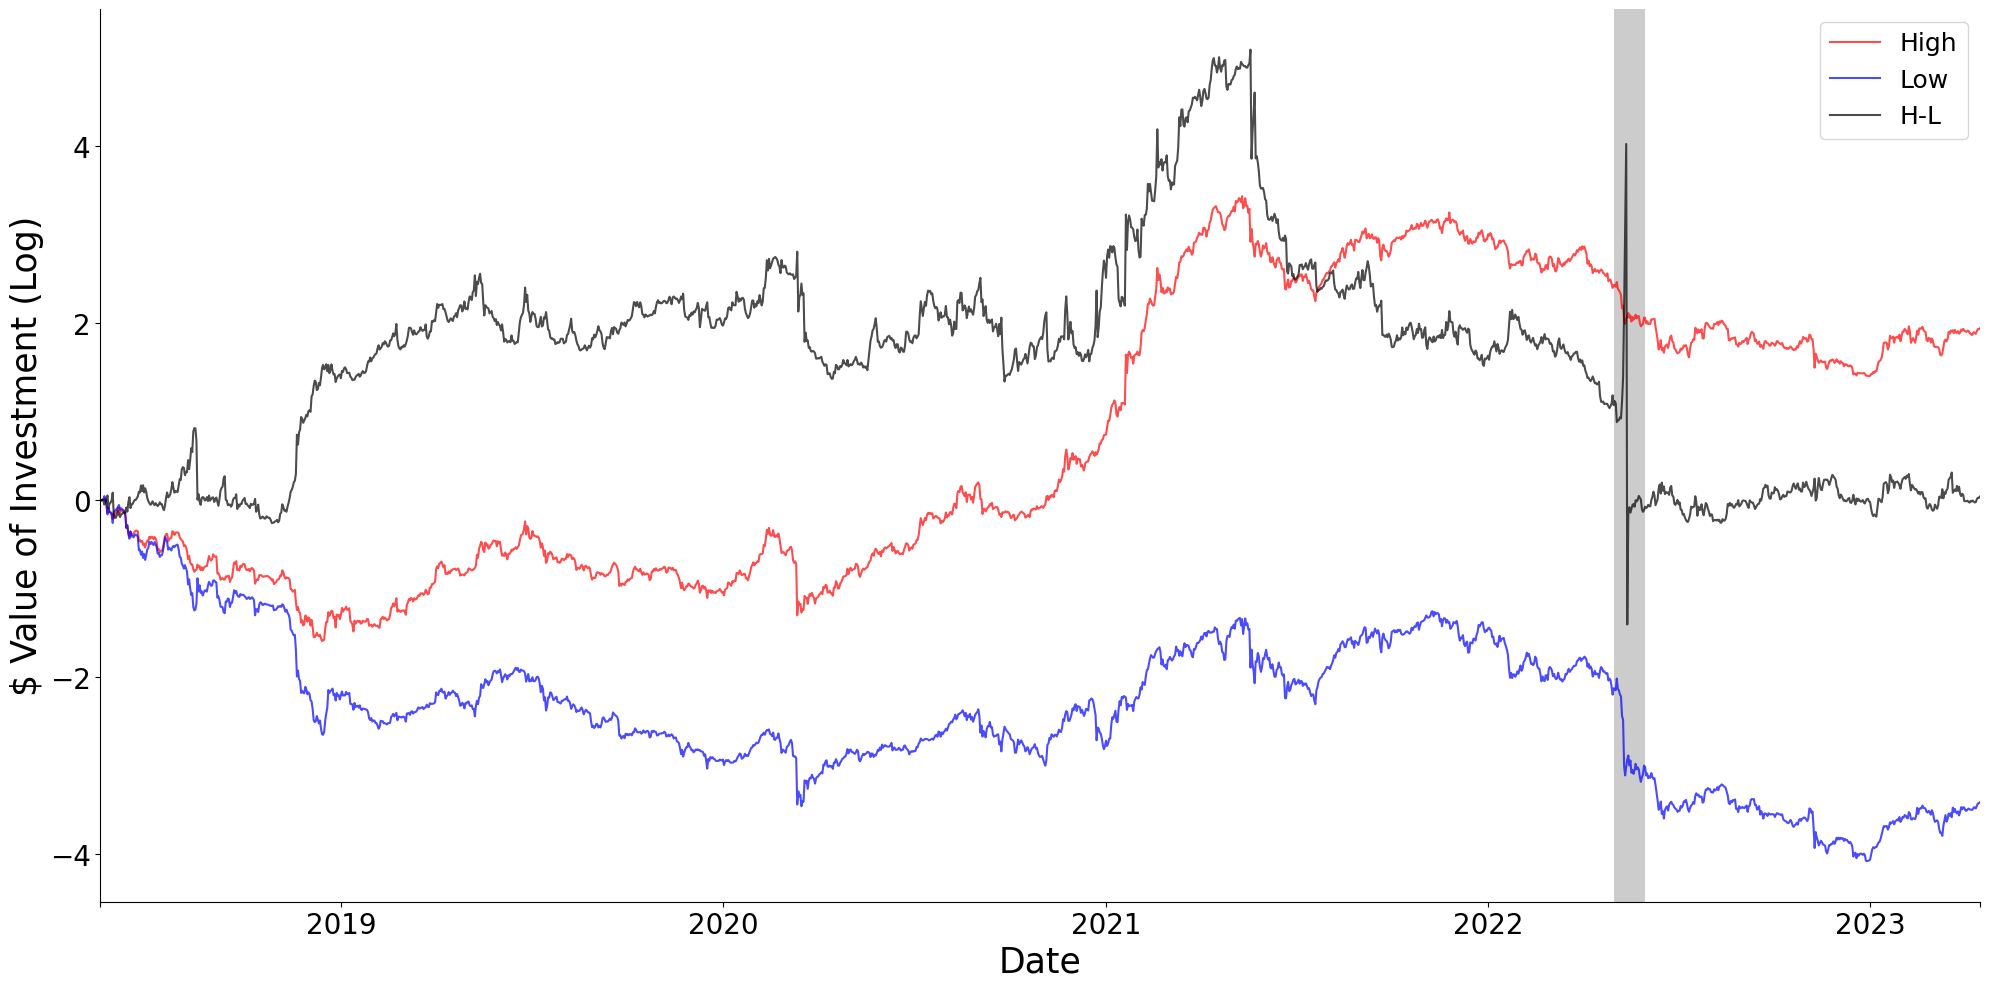

In [14]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

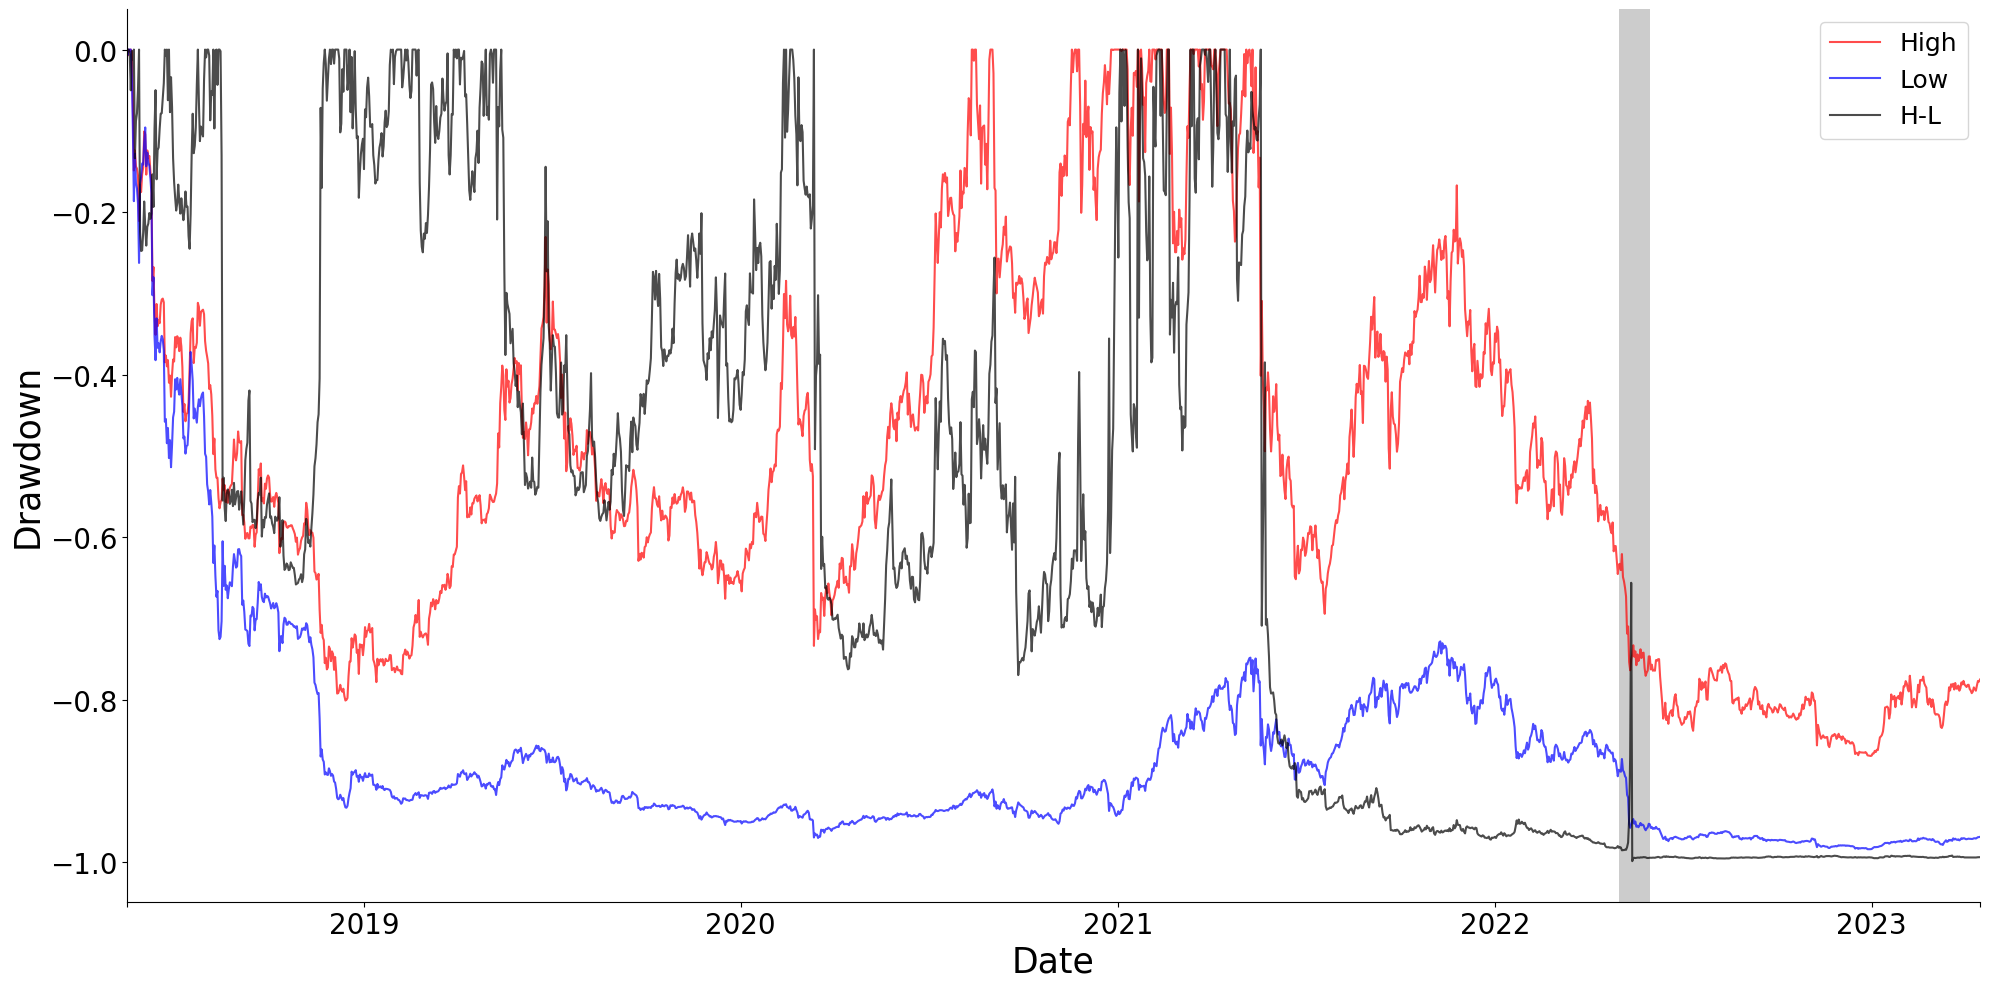

In [15]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [16]:
mytool.print_statistics(fin_c)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS
Mean,-0.179360,0.244110,0.168220,0.446660,0.858750,2.935410
STD,0.995508,0.865057,0.836097,0.841152,0.970994,2.421554
CAGR,-0.499900,-0.128000,-0.173500,0.086200,0.486100,0.008200
MDD,0.984000,0.878000,0.867000,0.815000,0.869000,0.998000
Sharpe,-0.180169,0.282189,0.201197,0.531010,0.884403,1.212201


Volume_weighted_capped

In [18]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_volume_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       #num_cap=0.95, # 5%,
                                                                       coin_group=10,
                                                                       leverage_ratio=2
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [19]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [20]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c2 = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c2[pf] = concat_series_c.sort_index().pct_change().fillna(0)

c:\Users\user\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


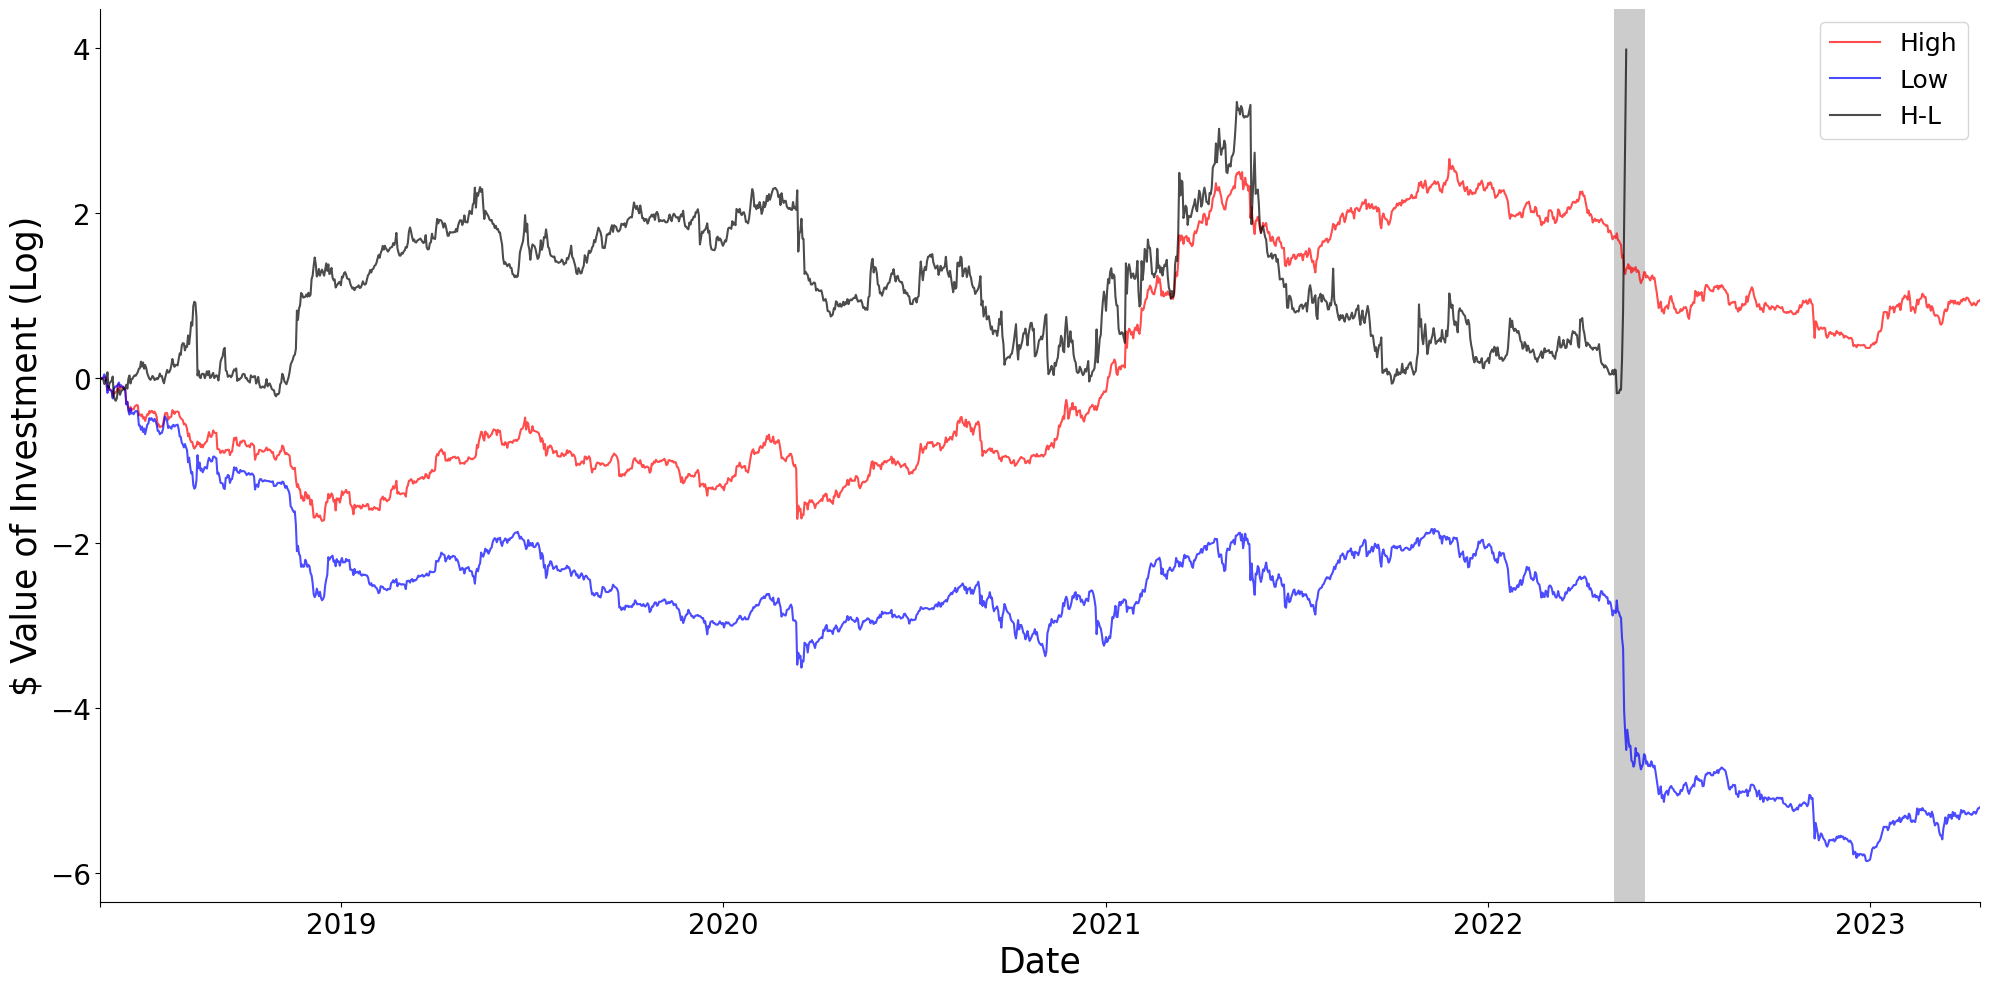

In [21]:
import matplotlib.dates as mdates

np.log((fin_c2["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c2["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c2["LS"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

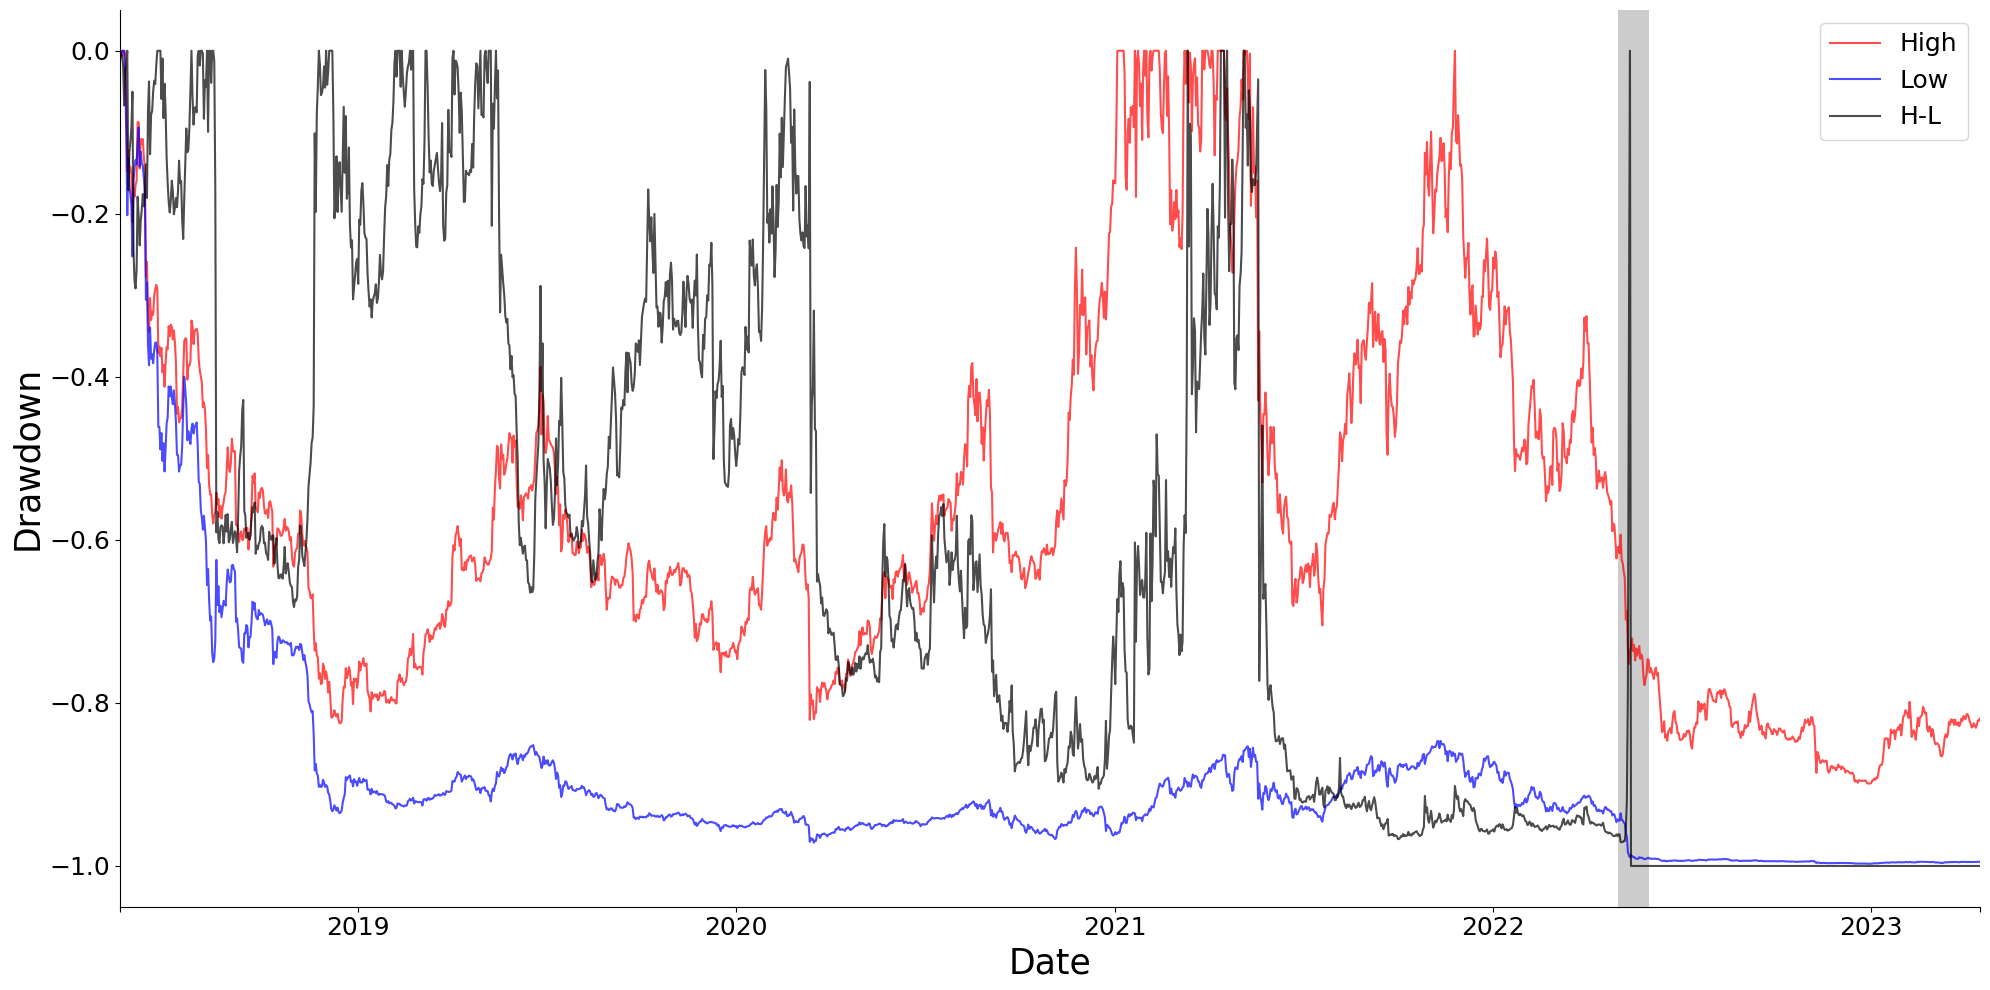

In [22]:
high = (fin_c2["Long_Q5"] + 1).cumprod()
low = (fin_c2["Long_Q1"] + 1).cumprod()
h_l = (fin_c2["LS"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=18)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.legend(["High", "Low","H-L"], fontsize=18)

plt.minorticks_off()
plt.tight_layout();

In [23]:
mytool.print_statistics({"a":fin_c['LS'].loc[:'2022-04'],
                         'vol':fin_c2['LS'].loc[:'2022-04']})

,a,vol
Mean,1.940960,2.146320
STD,1.874334,2.121982
CAGR,0.348600,0.027100
MDD,0.983000,0.967000
Sharpe,1.035547,1.011469


In [24]:
mytool.print_statistics(fin_c2)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS
Mean,-0.453560,0.177600,0.139100,0.322470,0.710150,2.880480
STD,1.068980,0.887260,0.857784,0.860208,1.015730,2.480192
CAGR,-0.652000,-0.200400,-0.212700,-0.057300,0.214600,-1.000000
MDD,0.997000,0.882000,0.892000,0.857000,0.899000,1.000000
Sharpe,-0.424292,0.200167,0.162162,0.374874,0.699152,1.161394


In [29]:
mytool.print_statistics({"mkt":mkt.loc[fin_c2['LS'].index]})

,mkt
Mean,0.417570
STD,0.739808
CAGR,0.157400
MDD,0.785000
Sharpe,0.564430


In [30]:
fin_c2['LS'].index

DatetimeIndex(['2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19',
               '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25',
               ...
               '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10',
               '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
               '2023-04-15', '2023-04-16'],
              dtype='datetime64[ns]', length=1797, freq=None)

In [33]:
# Import necessary modules
import yfinance as yf

# Download S&P500 data
data = yf.download('^GSPC', start='2000-01-01', end='2023-08-19')

# Print first few rows of the data

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971  \
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  
Date                    
2000-01-03   931800000  
2000-01-04  1009000000  
2000-01-05  1085500000  
2000-01-06  1092300000  
2000-01-07  1225200000  


In [40]:
mytool.print_statistics({"spx":data.Close.pct_change().loc['2013-12-28':'2023-04-16']})

,spx
Mean,0.150290
STD,0.217939
CAGR,0.134100
MDD,0.339000
Sharpe,0.689597


No cap

In [ ]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                mktcap_df=ray_mktcap,
                                                                daily_rtn_df = ray_daily_rtn,
                                                                weekly_rtn_df = ray_weekly_rtn,
                                                                mask_df = ray_mask,
                                                                fee_rate = 0.0015,
                                                                n_group=5,
                                                                day_of_week=day,
                                                                ) 
              for day in days_lst]

momentum_result = ray.get(momentum_future)

In [ ]:
momentum_result_dict = {"MON":momentum_result[0],
                        "TUE":momentum_result[1],
                        "WED":momentum_result[2],
                        "THU":momentum_result[3],
                        "FRI":momentum_result[4],
                        "SAT":momentum_result[5],
                        "SUN":momentum_result[6]}

In [ ]:
final = {}

for day in days_lst:
    df_day = momentum_result_dict[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final[day] = concat_df

fin = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series = pd.concat([df[pf] for key, df in final.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series.index[0] - pd.Timedelta(days=1)
    concat_series[start_idx] = 7
    fin[pf] = concat_series.sort_index().pct_change().fillna(0)

In [ ]:
np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("\$ Value of Investment(Log)", fontsize=18)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
mytool.print_statistics(fin_c)

j-k Momentum

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_momentum_value_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                                   daily_rtn_df = ray_daily_rtn,
                                                                   mask_df = ray_mask,
                                                                   fee_rate = 0.0015,
                                                                   n_group=5,
                                                                   day_of_week=day,
                                                                   num_cap=0.95 # 5%
                                                                    ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2

vol weighted jk

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_volume_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                           vol_df = ray_vol,
                                                           daily_rtn_df = ray_daily_rtn,
                                                           mask_df = ray_mask,
                                                           fee_rate = 0.0015,
                                                           n_group=5,
                                                           day_of_week=day,
                                                           num_cap=0.95 # 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2